# CS 593 Final Project

## Team Members
Noah Suttora, Michelle Morrone, Aditi Duggal

## The Dataset
The MovieLens 25M dataset is a stable benchmark dataset holding 25 million ratings and one million tag applications applied to 62,000 movies by 162,000 users. The dataset was released 12/2019.

## Concepts & Algorithms Used
- Sparseness to efficiently represent the gigantic dataset
- Content-Based Filtering
- Collaborative Filtering
- Matrix Factorization Using SVD

In [1]:
# general packages
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

# graphing packages
import matplotlib.pyplot as plt
import seaborn as sns

# content-based filtering packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# collaborative filtering packages
from sklearn.neighbors import NearestNeighbors

# matrix factorization packages
from scipy.sparse.linalg import svds

# configuration settings
np.set_printoptions(threshold=np.inf)

# Loading Data

In [2]:
# dataframe that holds movie info
movies = pd.read_csv('ml-25m/movies.csv')
print(movies.shape)
movies.head()

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# dataframe that holds rating info
ratings = pd.read_csv('ml-25m/ratings.csv', usecols=['userId', 'movieId', 'rating'])
print(ratings.shape)
ratings.head()

(25000095, 3)


,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


# Initial Preprocessing

In [4]:
# extract the year in the parenthesis of each movie title
year_col = movies['title'].str.extract(r'\((\d{4})\)')
year_col.columns = ['year']
# append new column to hold year of movie
movies = pd.concat([movies, year_col], axis=1)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [5]:
# clean the title
movies['title'] = movies['title'].str.replace(r'\s\((\d{4})\)', '',regex=True)
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [6]:
# there are some duplicate movies with different genres listed for the same movie
movies[movies.duplicated(['title', 'year'])]

,movieId,title,genres,year
9065,26982,Men with Guns,Drama,1997
12909,64997,War of the Worlds,Action|Sci-Fi,2005
12984,65665,Hamlet,Drama,2000
13177,67459,Chaos,Crime|Drama|Horror,2005
16120,85070,Blackout,Drama,2007
...,...,...,...,...
61521,206117,The Lonely Island Presents: The Unauthorized B...,Comedy,2019
61525,206125,Lost & Found,Comedy|Drama,2018
61697,206674,Camino,Comedy,2016
61800,206925,The Plague,Documentary,2006


In [7]:
# drop the duplicates since most of them have a subset of the same genres
movies.drop_duplicates(subset=['title', 'year'], keep='first', inplace=True)

# Exploratory Data Analysis

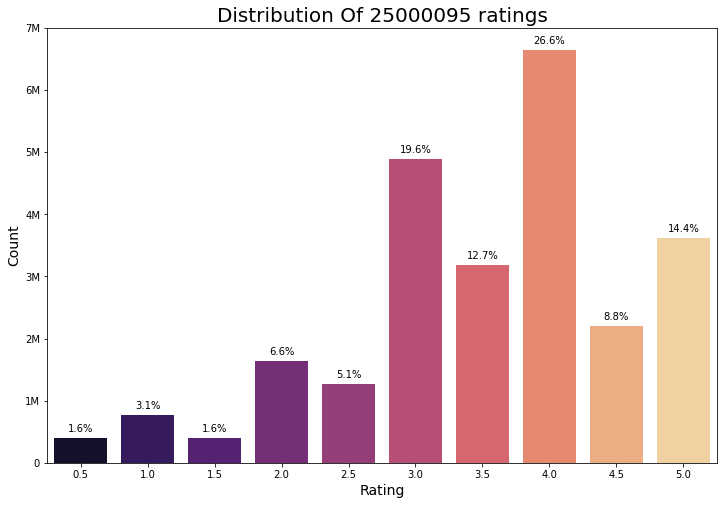

In [8]:
data = ratings['rating'].value_counts().sort_index(ascending=True)

# bar plot
plt.figure(figsize=(12, 8))
g = sns.barplot(x=data.index, y=data.values, palette='magma')
g.set_yticks(g.get_yticks().tolist())
g.set_yticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M'])
g.set_title('Distribution Of {} ratings'.format(ratings.shape[0]), fontsize=20)
g.set_xlabel('Rating', fontsize=14)
g.set_ylabel('Count', fontsize=14)

# percentage of distribution for each bar
percentage = [val for val in (data.values / ratings.shape[0] * 100)]
patches = g.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + (10**5)
    g.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
    
plt.show()

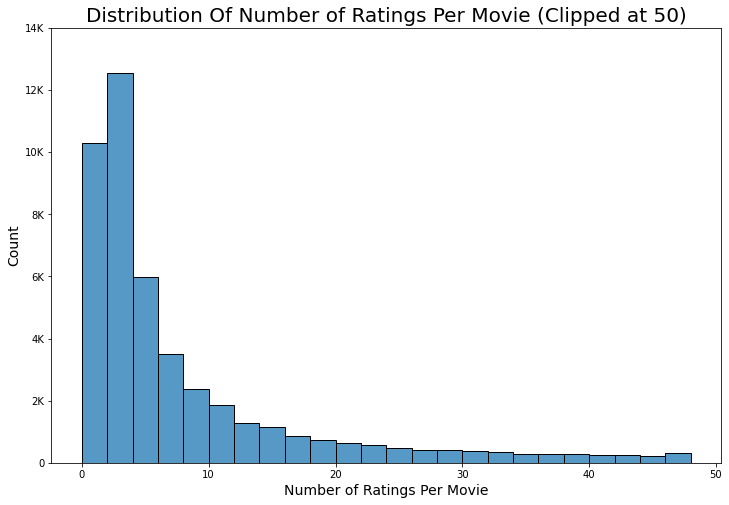

In [9]:
data = ratings.groupby('movieId')['rating'].count().clip(upper=50)

# histogram plot
plt.figure(figsize=(12, 8))
g = sns.histplot(x=data.values, bins=np.arange(0, 50, 2))
g.set_yticks(g.get_yticks().tolist())
g.set_yticklabels(['0', '2K', '4K', '6K', '8K', '10K', '12K', '14K'])
g.set_title('Distribution Of Number of Ratings Per Movie (Clipped at 50)', fontsize=20)
g.set_xlabel('Number of Ratings Per Movie', fontsize=14)
g.set_ylabel('Count', fontsize=14)
    
plt.show()

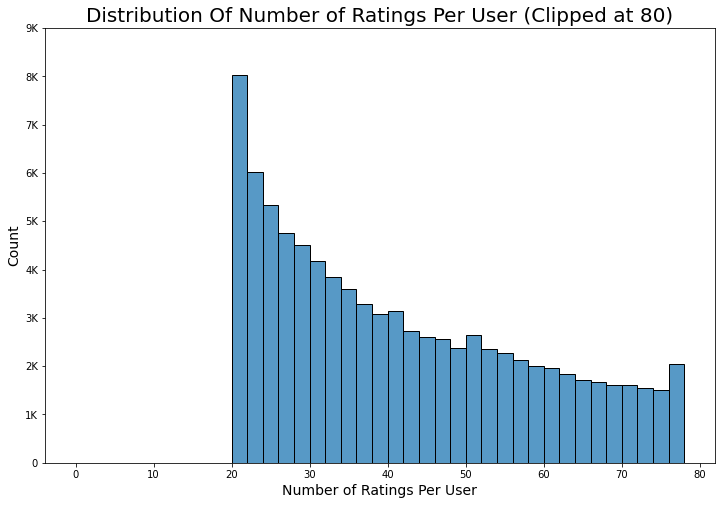

In [10]:
data = ratings.groupby('userId')['rating'].count().clip(upper=80)

# histogram plot
plt.figure(figsize=(12, 8))
g = sns.histplot(x=data.values, bins=np.arange(0, 80, 2))
g.set_yticks(g.get_yticks().tolist())
g.set_yticklabels(['0', '1K', '2K', '3K', '4K', '5K', '6K', '7K', '8K', '9K'])
g.set_title('Distribution Of Number of Ratings Per User (Clipped at 80)', fontsize=20)
g.set_xlabel('Number of Ratings Per User', fontsize=14)
g.set_ylabel('Count', fontsize=14)
    
plt.show()

In [11]:
title_year_group = movies.groupby(['year'])['title'].count()
title_year_group

year
1874       1
1878       1
1880       1
1883       1
1887       1
        ... 
2015    2504
2016    2476
2017    2362
2018    2028
2019     990
Name: title, Length: 135, dtype: int64

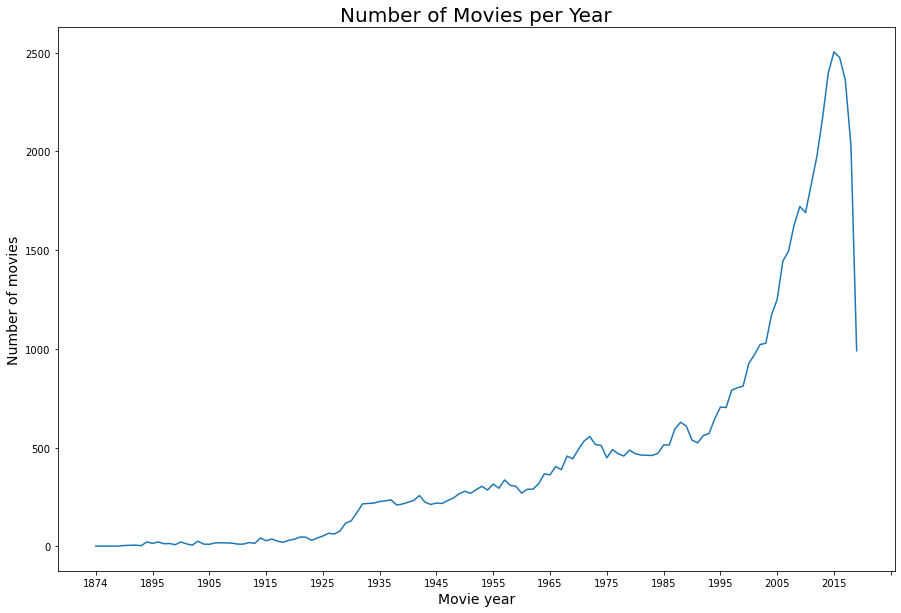

In [12]:
plt.figure(figsize=(15,10))
plt.plot(title_year_group.index, title_year_group.values)
plt.title('Number of Movies per Year', fontsize=20)
plt.xlabel('Movie year', fontsize=14)
plt.ylabel('Number of movies', fontsize=14)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140])
plt.show()

In [13]:
# dictionary to hold genre counts
genre_dic = {'(no genres listed)': 0, 'Action': 0, 'Adventure': 0, 'Animation': 0, 'Children': 0,
             'Comedy': 0, 'Crime': 0, 'Documentary': 0, 'Drama': 0, 'Fantasy': 0, 'Film-Noir': 0,
             'Horror': 0, 'IMAX': 0, 'Musical': 0, 'Mystery': 0, 'Romance': 0, 'Sci-Fi': 0,
             'Thriller': 0, 'War': 0, 'Western': 0}

# iterate through each movie's genre(s)
for genre in movies['genres'].values:
    genre = genre.split('|')
    # get the count value of the genre and increment by 1
    for gen in genre:
        genre_dic[gen] = genre_dic.get(gen, 0) + 1

# convert to dataframe
genre_counts = pd.DataFrame([genre_dic], index=['count']).T
genre_counts.sort_values(by='count', ascending=False, inplace=True)
genre_counts

,count
Drama,25569
Comedy,16849
Thriller,8631
Romance,7708
Action,7340
Horror,5973
Documentary,5596
Crime,5311
(no genres listed),5052
Adventure,4140


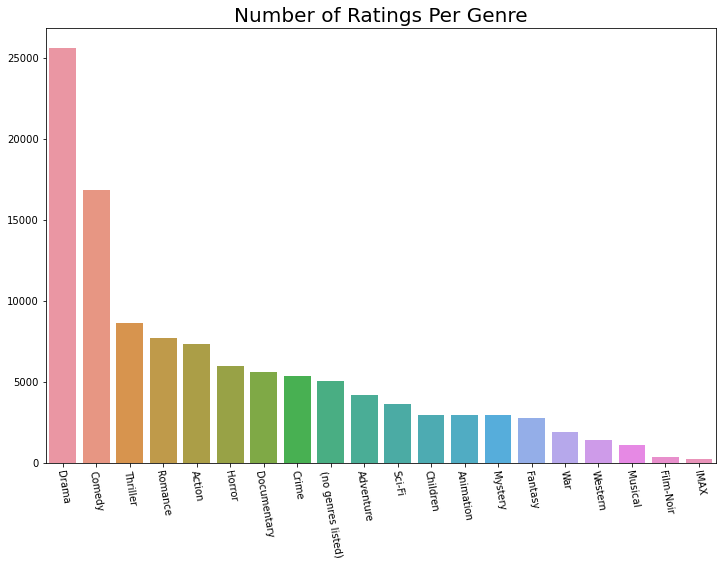

In [14]:
# bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.index, y=genre_counts.values.flatten())
plt.xticks(rotation=-80)
plt.title('Number of Ratings Per Genre', fontsize=20)
g.set_xlabel('Genres', fontsize=14)
g.set_ylabel('Count', fontsize=14)
plt.show()

# Preprocessing Dataframes

In [15]:
# combined dataframe of movies and ratings info
df = pd.merge(movies, ratings)
df

,movieId,title,genres,year,userId,rating
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,2,3.5
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,3,4.0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,4,3.0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,5,4.0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,8,4.0
...,...,...,...,...,...,...
24998451,209157,We,Drama,2018,119571,1.5
24998452,209159,Window of the Soul,Documentary,2001,115835,3.0
24998453,209163,Bad Poems,Comedy|Drama,2018,6964,4.5
24998454,209169,A Girl Thing,(no genres listed),2001,119571,3.0


In [16]:
# cannot create pivot table for utility matrix since it is too big
# to store the dense version (162541 x 59047 matrix -> 71.5 GiB storage needed)
print(len(df['userId'].unique()))
print(len(df['movieId'].unique()))

162541
58956


In [17]:
# convert unique values to categorical
userId_c = CategoricalDtype(sorted(df['userId'].unique()), ordered=True)
movieId_c = CategoricalDtype(sorted(df['movieId'].unique()), ordered=True)

# row of pivot table is userId categories
row = df['userId'].astype(userId_c).cat.codes
# col of pivot table is movieId categories
col = df['movieId'].astype(movieId_c).cat.codes

# create sparse coordinate representation of pivot table with row being
# userId, col being movieId, and values within being the user rating on that movie
util_mat_sparse = csr_matrix((df['rating'], (row, col)))
util_mat_sparse

<162541x58956 sparse matrix of type '<class 'numpy.float64'>'
	with 24998456 stored elements in Compressed Sparse Row format>

In [18]:
print(util_mat_sparse)

  (0, 292)	5.0
  (0, 302)	3.5
  (0, 303)	5.0
  (0, 654)	5.0
  (0, 878)	3.5
  (0, 1061)	4.0
  (0, 1147)	3.5
  (0, 1186)	3.5
  (0, 1205)	5.0
  (0, 1217)	4.0
  (0, 1227)	3.5
  (0, 1591)	4.0
  (0, 1922)	2.5
  (0, 1923)	2.5
  (0, 1979)	2.5
  (0, 2071)	3.5
  (0, 2260)	4.5
  (0, 2482)	4.0
  (0, 2541)	5.0
  (0, 2600)	5.0
  (0, 2751)	4.5
  (0, 3352)	4.0
  (0, 3470)	5.0
  (0, 3845)	5.0
  (0, 4040)	5.0
  :	:
  (162540, 6318)	4.5
  (162540, 6425)	3.0
  (162540, 6668)	4.5
  (162540, 6670)	0.5
  (162540, 6809)	2.0
  (162540, 6917)	3.5
  (162540, 6965)	4.5
  (162540, 7022)	4.5
  (162540, 7028)	5.0
  (162540, 7048)	1.5
  (162540, 7068)	5.0
  (162540, 7236)	4.5
  (162540, 7897)	2.5
  (162540, 8190)	3.0
  (162540, 8246)	4.0
  (162540, 8268)	4.5
  (162540, 9590)	4.5
  (162540, 9999)	4.0
  (162540, 10447)	4.0
  (162540, 10807)	4.5
  (162540, 11358)	4.5
  (162540, 11924)	2.5
  (162540, 11971)	2.0
  (162540, 12215)	4.0
  (162540, 12818)	5.0


In [19]:
# looking at first 10 rows, 10 cols in dense format to make sure it is correct
util_mat_sparse[0:10, 0:10].todense()

matrix([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [3.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [3. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 3. ],
        [4. , 0. , 4. , 0. , 0. , 3. , 1. , 0. , 0. , 4. ],
        [0. , 5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [3.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [20]:
check_df = df.iloc[:10000000,:]
check_df.pivot_table(index = ['userId'], columns = ['movieId'], values = 'rating').fillna(0).head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> The csr representation seems to be correct

In [20]:
# sparsity measure of utility matrix
nonzero_count = util_mat_sparse.count_nonzero()
total_elements = util_mat_sparse.shape[0] * util_mat_sparse.shape[1]
sparsity = 1.0 - (nonzero_count / total_elements)
print('Number of Non-Zero Elements of Utility Matrix: ', nonzero_count)
print('Total Number of Elements of Utility Matrix:    ', total_elements)
print('Percent Sparseness of Utility Matrix:           {:.2%}'.format(sparsity))

Number of Non-Zero Elements of Utility Matrix:  24998456
Total Number of Elements of Utility Matrix:     9582767196
Percent Sparseness of Utility Matrix:           99.74%


# Content-Based Filtering
* User is recommended items based on other items similar to what the user prefers
* For this dataset, the recommendation of the item will be based on similar movie genres

In [21]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [22]:
# testing on first 3 genres
tf = TfidfVectorizer(analyzer='word')
tf.fit(movies['genres'][0:3].values)
tf.get_feature_names()

['adventure', 'animation', 'children', 'comedy', 'fantasy', 'romance']

In [23]:
movies.iloc[31]

movieId                                    32
title      Twelve Monkeys (a.k.a. 12 Monkeys)
genres                Mystery|Sci-Fi|Thriller
year                                     1995
Name: 31, dtype: object

In [24]:
movies['genres'][31].split('|')

['Mystery', 'Sci-Fi', 'Thriller']

In [25]:
tf = TfidfVectorizer(tokenizer=lambda s: s.split('|'), token_pattern=None)
tf_idf_mat = tf.fit_transform(movies['genres'].values)
# all unique genres
tf.get_feature_names()

['(no genres listed)',
 'action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'film-noir',
 'horror',
 'imax',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'thriller',
 'war',
 'western']

In [26]:
tfidf_df = pd.DataFrame(tf_idf_mat.todense(), columns=tf.get_feature_names(), index=movies['title'])
tfidf_df.head()

,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
title,,,,,,,,,,,,,,,,,,,,
Toy Story,0.0,0.0,0.446576,0.488283,0.488078,0.277712,0.0,0.0,0.000000,0.496796,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Jumanji,0.0,0.0,0.539788,0.000000,0.589951,0.000000,0.0,0.0,0.000000,0.600489,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Grumpier Old Men,0.0,0.0,0.000000,0.000000,0.000000,0.598428,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.801176,0.0,0.0,0.0,0.0
Waiting to Exhale,0.0,0.0,0.000000,0.000000,0.000000,0.537321,0.0,0.0,0.440225,0.000000,0.0,0.0,0.0,0.0,0.0,0.719366,0.0,0.0,0.0,0.0
Father of the Bride Part II,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [27]:
# Vector similarity using cosine similarity
cosine_sim = cosine_similarity(tfidf_df)

In [28]:
cos_sim_df = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])
cos_sim_df.shape

(62325, 62325)

In [29]:
cos_sim_df.head()

title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Liberté,The Carpet of Horror,Mao Zedong 1949,Happy Flight,Santosh Subramaniam,We,Window of the Soul,Bad Poems,A Girl Thing,Women of Devil's Island
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,1.000000,0.827319,0.166191,0.149220,0.277712,0.0,0.166191,0.661551,0.0,0.290782,...,0.000000,0.0,0.0,0.214820,0.128897,0.000000,0.0,0.214820,0.0,0.317781
Jumanji,0.827319,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.799633,0.0,0.351475,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.384110
Grumpier Old Men,0.166191,0.000000,1.000000,0.897887,0.598428,0.0,1.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.462905,0.775598,0.000000,0.0,0.462905,0.0,0.000000
Waiting to Exhale,0.149220,0.000000,0.897887,1.000000,0.537321,0.0,0.897887,0.000000,0.0,0.000000,...,0.440225,0.0,0.0,0.694631,0.696400,0.440225,0.0,0.694631,0.0,0.159605
Father of the Bride Part II,0.277712,0.000000,0.598428,0.537321,1.000000,0.0,0.598428,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.773535,0.464140,0.000000,0.0,0.773535,0.0,0.000000


In [30]:
def genre_recommendations(index, sim_df, items, k):

    ix = sim_df.loc[:,index].to_numpy().argpartition(range(-1,-k,-1))
    closest = sim_df.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(index, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [31]:
#Testing genre recommendation
movies[movies.title.eq('Toy Story')]

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


In [34]:
genre_recommendations('Toy Story', cos_sim_df, movies[['title', 'genres','year']], 15)

,title,genres,year
0,Missing Link,Adventure|Animation|Children|Comedy|Fantasy,2019
1,UglyDolls,Adventure|Animation|Children|Comedy|Fantasy,2019
2,Scooby-Doo! Mask of the Blue Falcon,Adventure|Animation|Children|Comedy|Fantasy,2012
3,Shrek the Third,Adventure|Animation|Children|Comedy|Fantasy,2007
4,Puss in Book: Trapped in an Epic Tale,Adventure|Animation|Children|Comedy|Fantasy,2017
5,Moana,Documentary,1926
6,Moana,Adventure|Animation|Children|Comedy|Fantasy,2016
7,Wonder Park,Adventure|Animation|Children|Comedy|Fantasy,2019
8,Brother Bear 2,Adventure|Animation|Children|Comedy|Fantasy,2006
9,The Magic Crystal,Adventure|Animation|Children|Comedy|Fantasy,2011


In [35]:
#Let's try some more examples
movies[movies.title.eq('Saving Private Ryan')]

,movieId,title,genres,year
1939,2028,Saving Private Ryan,Action|Drama|War,1998


In [46]:
genre_recommendations('Saving Private Ryan', cos_sim_df, movies[['title', 'genres','year']], 15)

,title,genres,year
0,The Battalion,Action|Drama|War,2015
1,Seas Beneath,Action|Drama|War,1931
2,Victory (a.k.a. Escape to Victory),Action|Drama|War,1981
3,Tali-Ihantala 1944,Action|Drama|War,2007
4,The Fortress,Action|Drama|War,2017
5,"Bridge Too Far, A",Action|Drama|War,1977
6,The Great Raid,Action|Drama|War,2005
7,Chittagong,Action|Drama|War,2012
8,Seal Team Eight: Behind Enemy Lines,Action|Drama|War,2014
9,Hamburger Hill,Action|Drama|War,1987


In [47]:
movies[movies.title.eq('Strange Days')]

,movieId,title,genres,year
196,198,Strange Days,Action|Crime|Drama|Mystery|Sci-Fi|Thriller,1995


In [52]:
genre_recommendations('Strange Days', cos_sim_df, movies[['title', 'genres', 'year']], 20)

,title,genres,year
0,Minority Report,Action|Crime|Mystery|Sci-Fi|Thriller,2002
1,"X-Files: Fight the Future, The",Action|Crime|Mystery|Sci-Fi|Thriller,1998
2,Talking to Heaven,Crime|Drama|Mystery|Sci-Fi|Thriller,2002
3,"Groundstar Conspiracy, The",Action|Crime|Mystery|Romance|Sci-Fi|Thriller,1972
4,Knowing,Action|Drama|Mystery|Sci-Fi|Thriller,2009
5,Source Code,Action|Drama|Mystery|Sci-Fi|Thriller,2011
6,S. Darko (S. Darko: A Donnie Darko Tale),Crime|Mystery|Sci-Fi|Thriller,2009
7,False Witness,Action|Crime|Drama|Mystery|Thriller,2009
8,Blackhat,Action|Crime|Drama|Mystery|Thriller,2015
9,Whiteout,Action|Crime|Drama|Mystery|Thriller,2009


# Collaborative Filtering
* User is recommended items that people with similar preferences liked in the past
* For this dataset, the recommendation of the item will be based on the utility matrix

In [28]:
check_df
pivot2 = check_df.pivot_table(index = ['title'], columns = ['userId'], values = 'rating').fillna(0)

In [29]:
pivot2.head(10)

userId,1,2,3,4,5,6,7,8,9,10,...,162532,162533,162534,162535,162536,162537,162538,162539,162540,162541
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
1-900 (06),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
12 Angry Men,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187 (One Eight Seven),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2 Days in the Valley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2 ou 3 choses que je sais d'elle (2 or 3 Things I Know About Her),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"20,000 Leagues Under the Sea",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
collab_mat = csr_matrix(pivot2.values)
collab_mat

<1986x161577 sparse matrix of type '<class 'numpy.float64'>'
	with 9992067 stored elements in Compressed Sparse Row format>

In [31]:

model = NearestNeighbors(n_neighbors=16, algorithm='brute', metric='cosine')
model.fit(collab_mat)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=16)

In [32]:
distances,suggestions = model.kneighbors(pivot2.iloc[10,:].values.reshape(1,-1))

In [33]:
distances

array([[0.        , 0.82179789, 0.83514924, 0.84706722, 0.85427207,
        0.86916019, 0.86928446, 0.87256551, 0.8741079 , 0.87461756,
        0.87678836, 0.88063476, 0.88093688, 0.88139225, 0.88384919,
        0.88464588]])

In [34]:
suggestions

array([[  10, 1844,  149,  215,  656,   35, 1208, 1686,  833,  429,  958,
         430,  185, 1697, 1715,  155]], dtype=int64)

In [35]:
for i in range(len(suggestions)):
    print(pivot2.index[suggestions[i]])

Index(['3 Ninjas: High Noon On Mega Mountain', 'Turbo: A Power Rangers Movie',
       'Barney's Great Adventure', 'Blank Check', 'Free Willy 3: The Rescue',
       'Air Bud', 'Mortal Kombat: Annihilation', 'Steel', 'Home Alone 3',
       'D2: The Mighty Ducks', 'Jungle2Jungle (a.k.a. Jungle 2 Jungle)',
       'D3: The Mighty Ducks', 'Beverly Hills Ninja', 'Street Fighter',
       'Super Mario Bros.', 'Batman & Robin'],
      dtype='object', name='title')


In [36]:
def collabrec(movie_name):
    movie_id=pivot2.index.get_loc(movie_name)
    if movie_id == []:
        print("I'm sorry, the movie ", movie_name, " is not in our system.")
        return []
    distances,suggestions = model.kneighbors(pivot2.iloc[movie_id,:].values.reshape(1,-1))
    collab_recoms = []
    for i in range(len(suggestions)):
        collab_recoms = collab_recoms + [pivot2.index[suggestions[i]]]
    return collab_recoms[0][1:]

In [37]:
collabrec('Toy Story')

Index(['Star Wars: Episode IV - A New Hope', 'Back to the Future',
       'Forrest Gump', 'Jurassic Park',
       'Star Wars: Episode VI - Return of the Jedi',
       'Independence Day (a.k.a. ID4)', 'Lion King, The', 'Aladdin',
       'Star Wars: Episode V - The Empire Strikes Back',
       'Men in Black (a.k.a. MIB)',
       'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)',
       'Pulp Fiction', 'Groundhog Day', 'Mission: Impossible',
       'Willy Wonka & the Chocolate Factory'],
      dtype='object', name='title')

In [38]:
collabrec('Forrest Gump')

Index(['Jurassic Park', 'Shawshank Redemption, The',
       'Silence of the Lambs, The', 'Pulp Fiction', 'Braveheart',
       'Terminator 2: Judgment Day', 'Schindler's List', 'Apollo 13',
       'Fugitive, The', 'Seven (a.k.a. Se7en)', 'Lion King, The', 'Speed',
       'Mrs. Doubtfire', 'Back to the Future', 'Toy Story'],
      dtype='object', name='title')

# Matrix Factorization Using SVD
* SVD $ (A = U \Sigma V^T) $
* For this dataset,
  * $ A $ is the utility matrix
  * $ U $ is the user features matrix, representing how much each user likes each feature
  * $ \Sigma $ is the diagonal matrix of weights (singular values)
  * $ V^T $ is the movie features matrix, representing how relevant each feature is to each movie

In [39]:
U, Sig, Vt = svds(util_mat_sparse[0:10000, 0:10000], k=30)
Sig = np.diag(Sig)
U.shape, Sig.shape, Vt.shape

((10000, 30), (30, 30), (30, 10000))

In [40]:
U_sparse = csr_matrix(U)
Sig_sparse = csr_matrix(Sig)
Vt_sparse = csr_matrix(Vt)
U_sparse, Sig_sparse, Vt_sparse

(<10000x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 300000 stored elements in Compressed Sparse Row format>,
 <30x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 30 stored elements in Compressed Sparse Row format>,
 <30x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 277710 stored elements in Compressed Sparse Row format>)

In [41]:
svd_recon = np.dot(np.dot(U_sparse, Sig_sparse), Vt_sparse)
preds_df = pd.DataFrame(svd_recon.todense(), columns=np.arange(1, 10000+1))
preds_df

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,-0.063589,0.017973,-0.079904,-0.039863,-0.087480,0.028390,-0.066461,-0.061369,0.038008,0.497213,...,0.040245,-0.000333,0.015698,0.002301,0.0,0.0,0.022624,0.010448,0.007255,0.224772
1,3.547513,0.546435,0.102502,-0.055321,-0.037955,0.588412,0.084532,0.036029,-0.049875,0.562065,...,-0.038555,0.000283,0.008031,0.000695,0.0,0.0,-0.005370,0.006057,0.009372,3.529946
2,1.175202,0.623179,-0.572127,-0.150340,-0.013090,0.862639,0.064846,-0.091751,-0.180186,0.224772,...,0.107410,0.002830,0.003201,0.000959,0.0,0.0,0.120841,0.010850,-0.007824,4.871049
3,2.527973,0.099757,-0.098747,-0.055897,-0.018604,0.213278,-0.006692,-0.034840,-0.008351,0.218831,...,-0.002485,-0.001677,-0.002887,0.003649,0.0,0.0,0.092166,0.001407,0.002714,2.533069
4,3.712058,0.921638,1.302873,0.160272,1.175558,1.443333,1.121547,0.071871,0.422456,1.281453,...,-0.008079,-0.000603,0.006200,0.001704,0.0,0.0,0.000215,0.028382,0.009951,0.297795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.473646,1.425219,0.249464,0.155178,0.369894,0.574121,0.524307,0.200828,-0.018417,0.663605,...,-0.014529,0.000100,0.017726,-0.001941,0.0,0.0,-0.002446,0.019512,0.007708,0.160717
9996,2.066546,-0.269631,0.049121,0.039267,0.058545,0.827420,-0.170812,-0.102328,-0.023940,0.310767,...,-0.005335,-0.000002,0.000849,0.002210,0.0,0.0,0.006425,-0.003013,0.009383,-0.105186
9997,1.111994,0.484830,-0.084688,-0.032864,0.015061,3.477208,0.417095,-0.037836,0.068550,1.064493,...,0.059408,0.000982,0.008277,-0.008891,0.0,0.0,0.028487,-0.018962,-0.002770,3.756303
9998,1.320365,0.171491,0.222037,-0.060502,0.069053,2.096894,0.207332,-0.006437,0.355995,2.053040,...,0.003186,-0.000548,-0.005024,-0.001735,0.0,0.0,-0.022593,-0.022161,-0.001129,0.066170


In [42]:
def svd_recommendation(userId):
    # get index of similar neighbors
    neighbors = cosine_similarity(preds_df)
    neighbors = np.argsort(neighbors.T)
    
    # skip first smallest distance since it's itself
    top_five_neigh = np.flip(neighbors[userId-1])[1:10]
    
    # get the recommendations
    svd_recoms = movies[movies['movieId'].isin(top_five_neigh)]
    
    return svd_recoms

In [43]:
svd_recommendation(userId=1)

,movieId,title,genres,year
1171,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western,1966
3897,4001,Code of Silence,Action,1985
4399,4504,Feds,Comedy,1988
4584,4689,"Cat o' Nine Tails, The (Gatto a nove code, Il)",Mystery|Thriller,1971
5243,5351,Warm Water Under a Red Bridge (Akai hashi no s...,Comedy|Drama,2001
5272,5380,"Importance of Being Earnest, The",Comedy|Drama|Romance,2002


In [44]:
svd_recommendation(userId=20)

,movieId,title,genres,year
719,734,Getting Away With Murder,Comedy,1996
746,762,Striptease,Comedy|Crime,1996
3293,3388,Harry and the Hendersons,Children|Comedy,1987
3402,3500,Mr. Saturday Night,Comedy|Drama,1992
4518,4623,Major League,Comedy,1989
7546,7936,Shame (Skammen),Drama|War,1968


In [45]:
svd_recommendation(userId=100)

,movieId,title,genres,year
1472,1524,"Turning, The",Drama,1992
4405,4510,Heartbreak Hotel,Comedy,1988
4674,4780,Liam,Drama,2000
5900,6012,"Guy Thing, A",Comedy|Romance,2003
6484,6607,"Red Pony, The",Drama,1949
6516,6639,Wait Until Dark,Drama|Thriller,1967
7544,7934,Zelig,Comedy,1983
